
<style>
.prompt { min-width: 0ex; }
div.prompt { width: 0ex; }
</style>

# Apps Features that affect ratings on the Apple Store
## by Yaser Haitham Alosh

## Investigation Overview

I will be exploring a dataset of apps on the Apple Store, it contains info such as prices and ratings of them. It was published on Kaggle by Ramanathan [here](https://www.kaggle.com/ramamet4/app-store-apple-data-set-10k-apps)

I will be looking at apps with the best ratings, to answer questions like: What characteristics do they have? What features contribute the most to their high rating? Are they mostly Paid or Free?

I believe the primary variables that will have a strong effect are: price, number of supported devices, number of supported languages, and the genre.  


## Dataset Overview

The dataset contains 7195 unique apps.  The main important variables are: app price, user ratings, total ratings count ,app size, primary genre, number of supported devices and number of supported languages.

In [2]:
# import all packages and set plots to be embedded inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline
# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")
#%config InlineBackend.figure_formats = ['svg']
plt.figure(figsize=(12,6))

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

In [3]:
# load in the dataset into a pandas dataframe
apps = pd.read_csv('AppleStore.csv')
apps.head(3)

,Unnamed: 0,id,track_name,size_bytes,currency,price,rating_count_tot,rating_count_ver,user_rating,user_rating_ver,ver,cont_rating,prime_genre,sup_devices.num,ipadSc_urls.num,lang.num,vpp_lic
0,1,281656475,PAC-MAN Premium,100788224,USD,3.99,21292,26,4.0,4.5,6.3.5,4+,Games,38,5,10,1
1,2,281796108,Evernote - stay organized,158578688,USD,0.00,161065,26,4.0,3.5,8.2.2,4+,Productivity,37,5,23,1
2,3,281940292,"WeatherBug - Local Weather, Radar, Maps, Alerts",100524032,USD,0.00,188583,2822,3.5,4.5,5.0.0,4+,Weather,37,5,3,1


## Cleaning

There are some cleaning and preprocessing steps I need to take before performing my analysis.  
I will write comments wherever possible so that following the steps will be as smooth as possible.

In [4]:
#Convert some column names
new_col_names = {"track_name":"app_name","rating_count_tot":"ratings_count_tot","rating_count_ver":"ratings_count_ver","user_rating":"avg_ratings","user_rating_ver":"avg_ratings_ver",
                 "cont_rating":"content_rating","prime_genre":"genre","sup_devices.num":"supp_devices_count","ipadSc_urls.num":"sc_count","lang.num":"lang_count"}
apps.rename(columns=new_col_names,inplace=True)
apps.columns

Index(['Unnamed: 0', 'id', 'app_name', 'size_bytes', 'currency', 'price',
       'ratings_count_tot', 'ratings_count_ver', 'avg_ratings',
       'avg_ratings_ver', 'ver', 'content_rating', 'genre',
       'supp_devices_count', 'sc_count', 'lang_count', 'vpp_lic'],
      dtype='object')

In [5]:
#Remove duplicates. There are only two apps with the same name, but they have different versions.
#Since there are only two apps with more than one version, I can remove them safely.
idx = apps[apps.app_name.duplicated(keep=False)]
#Get the minimum versions. Locate it through indexing then get the index.
apps.drop(idx[idx.ver.isin(idx.groupby('app_name').ver.min())].index,inplace=True)
apps.reset_index(drop=True,inplace=True)

In [6]:
#Remove useless columns
apps.drop(['Unnamed: 0','currency'],axis=1,inplace=True)

In [7]:
#Convert columns to appropriate types where needed.

#Set the order for the content rating column category
ordinal_content_rating = ['4+','9+','12+','17+']

ordered_cont = pd.api.types.CategoricalDtype(ordered=True,categories=ordinal_content_rating)
apps.content_rating = apps.content_rating.astype(ordered_cont)
#No order needed here, just convert the column type to category.
apps.genre = apps.genre.astype('category')


In [8]:
#Convert size_bytes column values to megabytes
apps['size_bytes'] = (apps['size_bytes'] / (10 ** 6)).astype('float64')
apps.rename(columns={'size_bytes':'size_mb'},inplace=True)

In [9]:
print(apps.dtypes)
print(apps.shape)
apps.head()

id                       int64
app_name                object
size_mb                float64
price                  float64
ratings_count_tot        int64
ratings_count_ver        int64
avg_ratings            float64
avg_ratings_ver        float64
ver                     object
content_rating        category
genre                 category
supp_devices_count       int64
sc_count                 int64
lang_count               int64
vpp_lic                  int64
dtype: object
(7195, 15)


,id,app_name,size_mb,price,ratings_count_tot,ratings_count_ver,avg_ratings,avg_ratings_ver,ver,content_rating,genre,supp_devices_count,sc_count,lang_count,vpp_lic
0,281656475,PAC-MAN Premium,100.788224,3.99,21292,26,4.0,4.5,6.3.5,4+,Games,38,5,10,1
1,281796108,Evernote - stay organized,158.578688,0.00,161065,26,4.0,3.5,8.2.2,4+,Productivity,37,5,23,1
2,281940292,"WeatherBug - Local Weather, Radar, Maps, Alerts",100.524032,0.00,188583,2822,3.5,4.5,5.0.0,4+,Weather,37,5,3,1
3,282614216,"eBay: Best App to Buy, Sell, Save! Online Shop...",128.512000,0.00,262241,649,4.0,4.5,5.10.0,12+,Shopping,37,5,9,1
4,282935706,Bible,92.774400,0.00,985920,5320,4.5,5.0,7.5.1,4+,Reference,37,5,45,1


In [10]:
#Defining some colors.
blue  = sb.color_palette()[0]
orange = sb.color_palette()[1]
green = sb.color_palette()[2]
red = sb.color_palette()[3]
light_blue = '#465362'#64a2ad'
dark_blue = '#011936'
light_orange = '#F4C43F'#e9c16a'
pink = '#ED254E'
dark_gold = '#C2A83E'
dark_green= '#244C38'
light_green = '#62C370'
#2274A5
#E6AF2E
#587792
#F2ED6F
#CEE397


## Distribution of Apps Average Ratings

Ratings range from 0 to 5, with most apps being between 4 and 5, which means they have a good rating.  
The 0's are unrated apps, they probably have a low install or users count. 
Ratings only take either a full number or with a half, like 2 or 2.5.

As a note, any rating below 4 is not considered a successful/good app, as most users won't download apps with low average ratings.


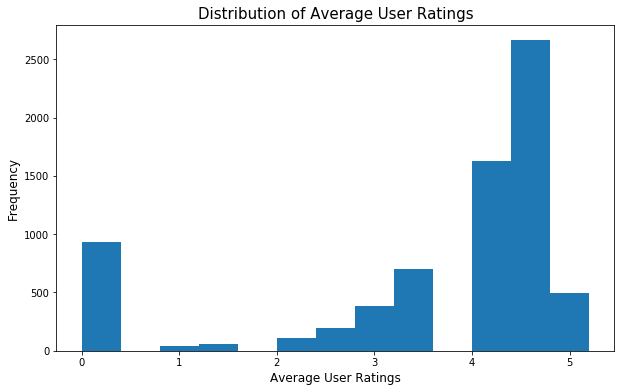

In [11]:
plt.figure(figsize=(10,6))

#Lowering the bin size helps showing that most of ratings are around 4 and 4.5, not 5.
bins = np.arange(0,apps.avg_ratings.max()+0.4,0.4)
plt.hist(data=apps,x='avg_ratings',bins=bins);
plt.xlabel('Average User Ratings',fontsize=12);
plt.ylabel('Frequency',fontsize=12)
plt.title('Distribution of Average User Ratings',size=15)
plt.show()

## Distribution of Prices

Paid apps have a wide range of prices, from 0.99 up to 200.  
However, they usually take on _standard prices_ like 0.99,1.99,2.99,3.99, and so on. Other prices exist but aren't as common.  
So from the plot on a logarithmic scale, prices usually are from 2 to 5$. With some other spikes on 7-9 and around 20. 


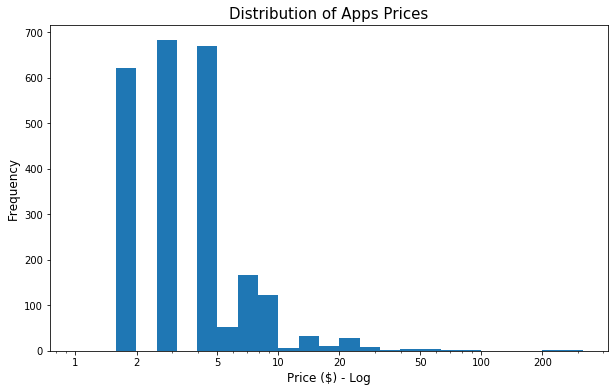

In [12]:
plt.figure(figsize=(10,6))

bins = 10 ** np.arange(0,np.log10(apps.price.max())+0.1,0.1)

plt.hist(data=apps,x='price',bins=bins);
plt.xlabel('Price ($) - Log',fontsize=12);
plt.xscale('log')
plt.xticks([1,2,5,10,20,50,100,200],[1,2,5,10,20,50,100,200])
plt.ylabel('Frequency',fontsize=12)
plt.title('Distribution of Apps Prices',size=15)
plt.show()

**Tip for app developers**
- Since most apps are priced below 30-35$, try to not go over or even reach that for your paid app.

In [13]:
apps.loc[apps[apps.lang_count == 0].index,'lang_count'] = 1

##  Price vs Ratings

For Paid apps, higher prices are associated with better average ranking, as the next plot shows, which graphs the log of price vs the Average Ratings.  
The other plot on the right graphs the price on the x-axis and the Log of the number of total ratings on the y axis.
It shows that higher priced apps are also associated with less total ratings count.  

One could argue that this decrease in total ratings count is the _cause_ for the high ratings, however this isn't true since as the number of total ratings increase the average ratings, generally, increase as well.

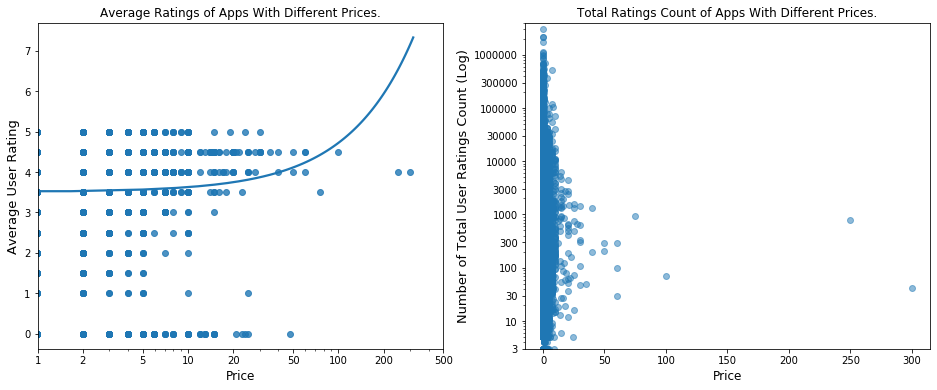

In [14]:
#Plotting Prices vs Average Rating, and Price vs Total ratings count on a log scale
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)

sb.regplot(data=apps,x='price',y='avg_ratings',ci=None)
plt.ylabel('Average User Rating',fontsize=13)
plt.xlabel('Price',fontsize=12)
plt.xscale('log')
xticks = [1,2,5,10,20,50,100,200,500]
plt.xticks(xticks,xticks)
plt.title('Average Ratings of Apps With Different Prices.')

plt.subplot(1,2,2)
plt.yscale('log')

sb.regplot(data=apps,x='price',y='ratings_count_tot',ci=None,scatter_kws={'alpha':1/2},fit_reg=False)
plt.ylabel('Number of Total User Ratings Count (Log)',fontsize=13)
plt.xlabel('Price',fontsize=12)
log_ticks = [3,10,30,100,300,1000,3000,10000,30000,100000,300000,1000000]
plt.yticks(log_ticks,log_ticks);
plt.title('Total Ratings Count of Apps With Different Prices.');

In [27]:
apps['paid'] = np.where(apps.price > 0,'Paid','Free')

In [15]:
LOW_THRESHOLD = 150
#Genres with small number of apps
uncommon_genres = apps.genre.value_counts()[apps.genre.value_counts() < LOW_THRESHOLD].index
apps['genre_top'] = apps.genre.astype(str)
apps.loc[apps[apps.genre_top.isin(uncommon_genres)].index,'genre_top'] = 'Other'

#Order the genre_top category
ordinal_top_genres = ['Games','Entertainment','Education','Photo & Video','Utilities','Health & Fitness','Productivity','Social Networking','Other']
ordered_genres = pd.api.types.CategoricalDtype(ordered=True,categories=ordinal_top_genres)

apps.genre_top = apps.genre_top.astype(ordered_genres)
print(uncommon_genres)
apps[apps.genre_top == 'Other'].head(3)


CategoricalIndex(['Lifestyle', 'Music', 'Shopping', 'Sports', 'Book',
                  'Finance', 'Travel', 'News', 'Weather', 'Reference',
                  'Food & Drink', 'Business', 'Navigation', 'Medical',
                  'Catalogs'],
                 categories=['Book', 'Business', 'Catalogs', 'Education', 'Entertainment', 'Finance', 'Food & Drink', 'Games', ...], ordered=False, dtype='category')


,id,app_name,size_mb,price,ratings_count_tot,ratings_count_ver,avg_ratings,avg_ratings_ver,ver,content_rating,genre,supp_devices_count,sc_count,lang_count,vpp_lic,genre_top
2,281940292,"WeatherBug - Local Weather, Radar, Maps, Alerts",100.524032,0.0,188583,2822,3.5,4.5,5.0.0,4+,Weather,37,5,3,1,Other
3,282614216,"eBay: Best App to Buy, Sell, Save! Online Shop...",128.512000,0.0,262241,649,4.0,4.5,5.10.0,12+,Shopping,37,5,9,1,Other
4,282935706,Bible,92.774400,0.0,985920,5320,4.5,5.0,7.5.1,4+,Reference,37,5,45,1,Other


## Apps Genres Ratings Distributions, and Free vs Paid

Now the next plot shows the frequency of apps per genre. It is useful to derive insights from the second plot.
The second plot shows the distribution of average ratings of each genre (Other genre is for genres with small number of apps)  

Interestingly, Productivity apps have the best ratings distribution of all, with the exception of its outliers.  
This might be because there is a small number of them, but Social Neworking apps have worse ratings and less number, so this isn't the cause.  

**Entertainment, Utilities and Social Networking** genres have a wide range of ratings, which is probably due to the fact that these genres are quite general and include many different sub-categories.    
The same goes for Other genre.  
**Games** on the other hand, have a balanced range or ratings, with most of games being around 4.5. The same goes for **Photo & Video** and **Health & Fitness** genres.


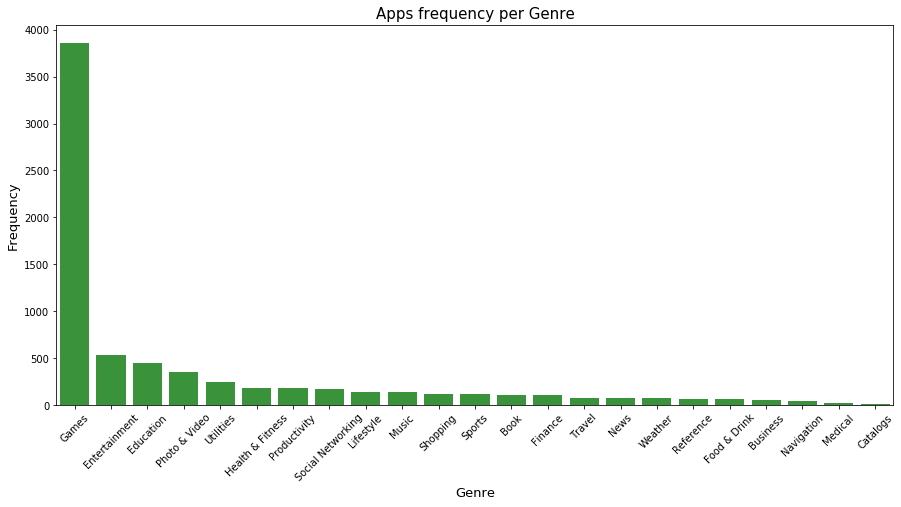

In [16]:
plt.figure(figsize=(15,7))

gen_order = apps.genre.value_counts().index

sb.countplot(data=apps,x='genre',color=green,order=gen_order);
plt.xlabel('Genre',fontsize=13)
plt.ylabel('Frequency',fontsize=13);
plt.title('Apps frequency per Genre',size=15);
plt.xticks(rotation=45);

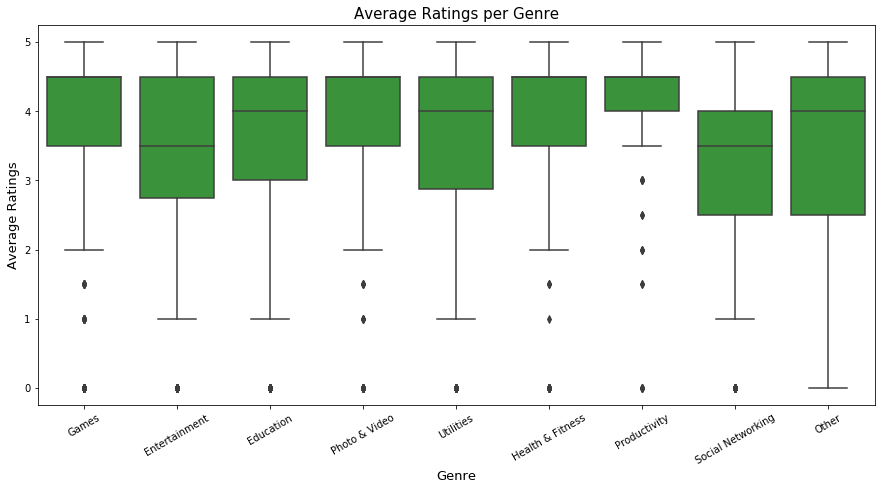

In [17]:
plt.figure(figsize=(15,7))

gen_order = apps.genre_top.value_counts().index

sb.boxplot(data=apps,x='genre_top',y='avg_ratings',color=green)
plt.xlabel('Genre',fontsize=13)
plt.ylabel('Average Ratings',fontsize=13)
plt.xticks(rotation=30)
plt.title('Average Ratings per Genre',size=15);

## How Languages and Apps Sizes affect Ratings 

The relation here is certainly not a cause-and-effect, it's simply a specific distribution.  
The first plot is a 2D histogram of the number of supported languages on the x-axis and the average ratings on the y-axis. The colors represent frequencies of points within each region.  
The same goes for the second, except it's for apps size, plotted on a log scale on the x-axis

For Languages support, it looks like even apps with 1-2 language take up mostly high ratings. However, as the count increases, the ratings certainly get better.  

As for apps sizes, most apps sizes range from 50 MB to 300 MB. Those certainly have higher ratings overall, since that's where most apps are at.  
But what matters to use is that for large apps sizes, going from 200 MB and upward,we see more apps with higher ratings.

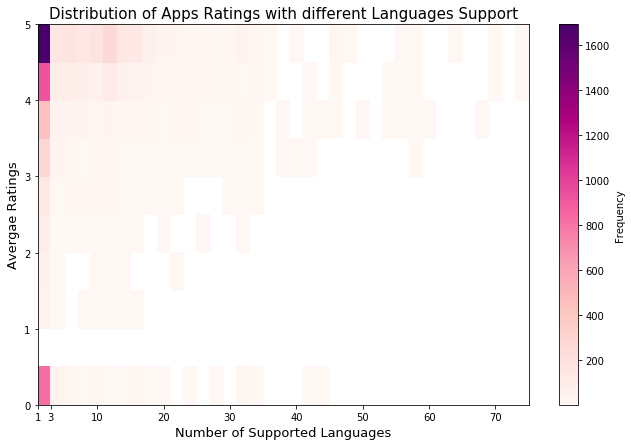

In [18]:
plt.figure(figsize=(11,7))
xbins = np.arange(1,apps['lang_count'].max()+2,2)
ybins = np.arange(0,apps['avg_ratings'].max()+0.5,0.5)
plt.hist2d(apps['lang_count'],apps['avg_ratings'],cmin=0.5,cmap='RdPu',bins=[xbins,ybins]);
plt.colorbar(label = 'Frequency')
plt.xlabel('Number of Supported Languages',fontsize=13)
plt.ylabel('Avergae Ratings',fontsize=13);
xticks  = [1,3,10,20,30,40,50,60,70]
plt.xticks(xticks,xticks);
plt.title('Distribution of Apps Ratings with different Languages Support',size=15);

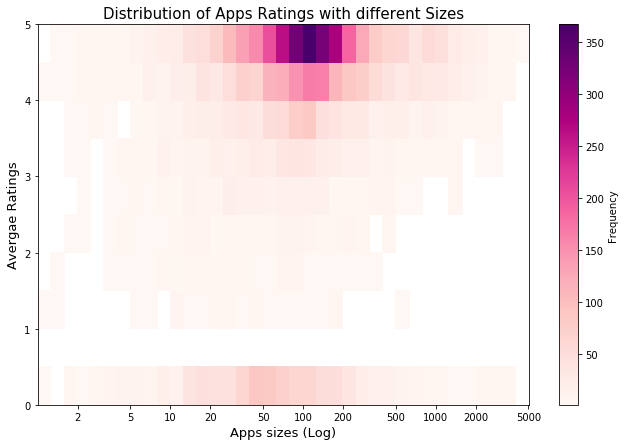

In [19]:
plt.figure(figsize=(11,7))

xbins = np.arange(0,np.log10(apps['size_mb']).max()+0.1,0.1)
ybins = np.arange(0,apps['avg_ratings'].max()+0.5,0.5)

plt.hist2d(np.log10(apps['size_mb']),apps['avg_ratings'],cmin=0.5,cmap='RdPu',bins=[xbins,ybins]);
plt.colorbar(label = 'Frequency')
plt.ylabel('Avergae Ratings',fontsize=13);
plt.xlabel('Apps sizes (Log)',fontsize=13);
xticks = [2,5,10,20,50,100,200,500,1000,2000,5000]
plt.xticks(np.log10(xticks),xticks);
plt.title('Distribution of Apps Ratings with different Sizes',size=15);

**Tips for app developers**
1. More content = larger sizes = generally better average ratings
2. Support at least 4 languages. Not any 4, of course. You probably need to support __English, Hindustani, Spanish and Arabic__. (Don't forget __Chineese__ if your app is global!)


In [22]:
apps['size_mb_log'] = np.log10(apps['size_mb'])
apps['lang_count_log'] = np.log10(apps['lang_count'])

## Apps sizes and Languages per Genre

My main focus is apps rating, but I would like to point something important about apps sizes and languages support.  
The first plot has the log of apps sizes on the y axis, and a violin plot per genre.  
We can see that Games and Education apps have the largest sizes, while Productivity and Utilities are the opposite.  
As for languages, work related apps generally support more languages.

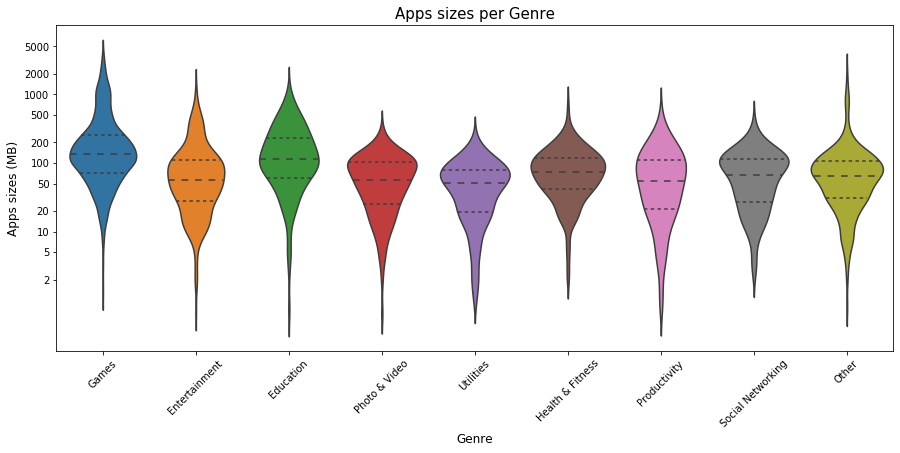

In [23]:
plt.figure(figsize=(15,6))

sb.violinplot(data=apps,x='genre_top',y='size_mb_log',inner='quartile')
plt.xticks(rotation=45);

yticks = [2,5,10,20,50,100,200,500,1000,2000,5000]
plt.yticks(np.log10(yticks),yticks);

plt.xlabel('Genre',fontsize=12)
plt.ylabel('Apps sizes (MB)',fontsize=12);
plt.title('Apps sizes per Genre',size=15);

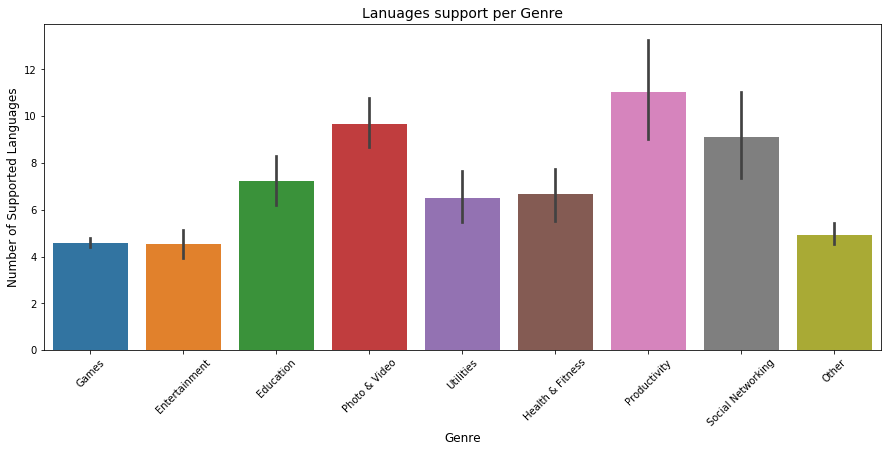

In [25]:
plt.figure(figsize=(15,6))
sb.barplot(data=apps,x='genre_top',y='lang_count')
plt.xticks(rotation=45);
plt.xlabel('Genre',fontsize=12)
plt.ylabel('Number of Supported Languages',fontsize=12);
plt.title('Lanuages support per Genre',size=14);


**Tips for app developers:**  
- If you're making a Photo & Video, Social Networking or Productivity app, you should generally support a wide range of languages.  
- If you're making a Utilities, Social Networking or Photo & Video apps, you should try to minimize the size of your apps.
- For Games, you need not worry about your game size, but try to stay below 500 MB.

## Total & Average Ratings of Genres - Free vs Paid Apps
Going back to our main quest, the next plot will help determining which genre is better to publish an app for given our goal is to maximize ratings, and whether the app should be Free or Paid.  

The plot shows the total ratings count on the left y axis which are resembled by the bars, and it shows the average ratings on the right y axis which are resembled by the lines.

I'm assuming that you want to minimize competition, in order to maximize success.

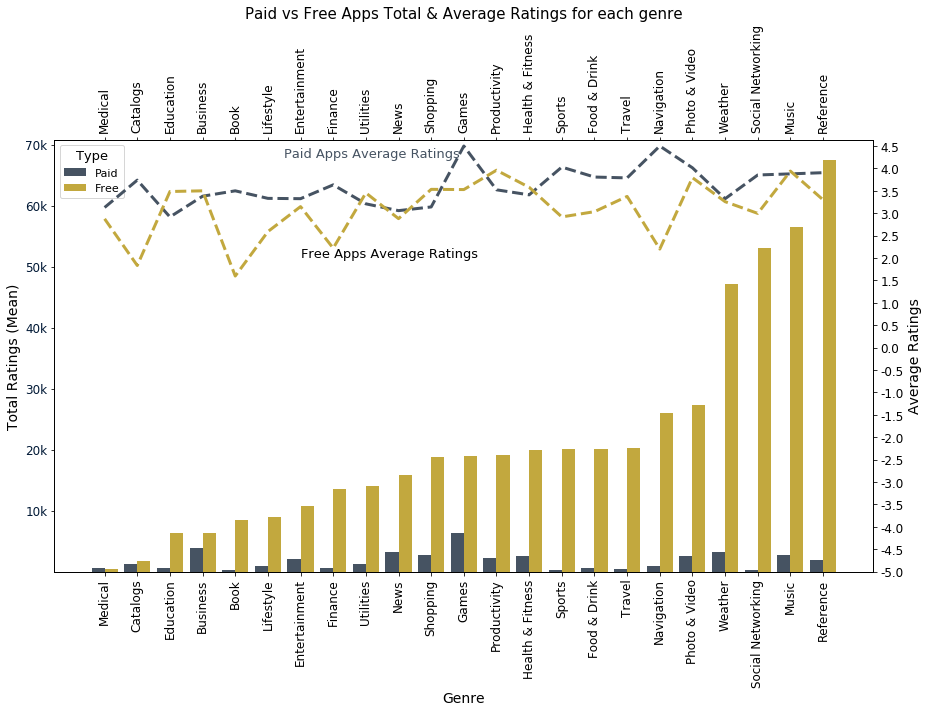

In [28]:
fig, ax1 = plt.subplots(figsize=(13,10))

plt.title('Paid vs Free Apps Total & Average Ratings for each genre',fontsize=15);
fig.subplots_adjust(top=0.8)

sorted_index = apps.query('paid == "Free"').groupby(['genre']).mean()['ratings_count_tot'].sort_values()

paid_sums = apps.query('paid == "Paid"').groupby('genre').mean()['ratings_count_tot'].reindex(sorted_index.index).values
free_sums = apps.query('paid == "Free"').groupby('genre').mean()['ratings_count_tot'].reindex(sorted_index.index).values
#Both paid and free sums have same length
x = np.arange(len(paid_sums))

genre_labels = apps.groupby('genre').mean().reset_index().genre
genre_labels = sorted_index.index

width = 0.4
bars1 = ax1.bar(x - width/2, paid_sums, width, label='Paid',color=light_blue)
bars2 = ax1.bar(x + width/2, free_sums, width, label='Free',color=dark_gold)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax1.set_ylabel('Total Ratings (Mean)',fontsize=14)
ax1.set_xlabel('Genre',fontsize=14)
#Ticks
ax1.set_xticks(x)
ax1.set_xticklabels(genre_labels,fontsize=12,rotation=90)
ax1.tick_params(axis='y', labelcolor=dark_blue)
ax1.set_yticks([1e4,2e4,3e4,4e4,5e4,6e4,7e4])
ax1.set_yticklabels(['10k','20k','30k','40k','50k','60k','70k'],fontsize=12)
#Legend
ax1.legend(title='Type',title_fontsize=13,fontsize=11)

#Clone it on x axis to allow multiple plots in same axes
ax2 = ax1.twinx()
means_paid = apps.query('paid == "Paid"').groupby(['genre']).mean().sort_values(by='ratings_count_tot')['avg_ratings']
means_free = apps.query('paid == "Free"').groupby(['genre']).mean().sort_values(by='ratings_count_tot')['avg_ratings']

ax2.set_zorder(5)
ax2.patch.set_visible(False)


ax2.plot(np.arange(len(means_paid)) ,means_paid.values, color=light_blue, label='Average Ratings - Paid Apps', linewidth=3,linestyle='dashed')
ax2.plot(np.arange(len(means_free)) ,means_free.values, color=dark_gold, label='Average Ratings - Free Apps', linewidth=3,linestyle='dashed')

#Set a wider y range to make the plot more compact
xticks = np.arange(-5, 5, 0.5)
ax2.set_yticks(xticks)
ax2.set_yticklabels(xticks,fontsize=12);
ax2.set_ylabel('Average Ratings',fontsize=14)

ax1.text(5.5, 68000, 'Paid Apps Average Ratings', color=light_blue,fontsize=13)
ax1.text(6,51500, 'Free Apps Average Ratings', color='black',fontsize=13)


ax3=ax1.twiny()
#Plot dummy invisible bars to set the  x ticks positions correctly
rects1 = ax3.bar(x - width/2, 0, width)
rects2 = ax3.bar(x + width/2, 0, width)
ax3.set_xticks(x)
ax3.set_xticklabels(genre_labels,rotation=90,fontsize=12)
ax3.xaxis.set_ticks_position("top")

fig.tight_layout()
plt.show()


Based on that, my suggestions for app developers now would be:
- If you want to publish for a market that is crowded, consider ones where the average ratings are not as high, such as  __Sports, Travel, Food & Drink__, to make the competition easier.
- If you're making an app for a niche market, a small target market, and you care more about maintaining its high quality and achiving a specific goal, then you should consider making it paid.  An example would be an app for bank transactions or a medical simulation app for trainees.
- If you're going for an uncommon market and want to reach as large of an audience as possible, make your app Free.
- If you're going for a game, then you can go with Free or Paid, you have a large enough user base and can get high ratings either way.
- Otherwise, _make your app Free_.


## Final Thoughts
For me, I prefer to publish Free apps rather than Paid apps, and I like to support as many languages as I expect I need, and I generally don't worry about the app size. Our examination of apps proved that those are key elements, however, they are just very broad tips and further investigation is needed.  

Obvious limitations of my exploration are:
- The data was quite small compared to all the apps available on the Apple Store
- Not enough features were present, such as download count.

Hopefully this slide deck was insightful for you.


In [ ]:
!jupyter nbconvert Apple_Store_Apps_Slide_Deck.ipynb --to slides --post serve --template output_toggle --SlidesExporter.reveal_theme=serif